# Battle of Neighborhoods - Week 2 

# Problem: Where to launch a Japanese restaurant in New York City?

In [7]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#!conda install -c conda-forge folium
import os
!pip install folium
import folium # map rendering library
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mp
import re
import csv
%matplotlib inline

print('Libraries imported.')

Libraries imported.


In [23]:
CLIENT_ID = 'V4AJ5AKTXSCGGTHJHLOIH1WLVJ4QGDYVJJWC25DQICGX5ZWM' # Foursquare ID, note there is a daily call quota limit 
CLIENT_SECRET ='BVM1BSNHUDIOEXK5PTMVWKRNUONX3K3Q1JOFQ2ABKZVYREXI' # Foursquare Secret, note there is a daily call quota limit
VERSION = '20200605' # Foursquare API version
radius=1000
LIMIT=100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: V4AJ5AKTXSCGGTHJHLOIH1WLVJ4QGDYVJJWC25DQICGX5ZWM
CLIENT_SECRET:BVM1BSNHUDIOEXK5PTMVWKRNUONX3K3Q1JOFQ2ABKZVYREXI


In [24]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [25]:
def get_venues(lat,lng):
    
    #set variables
    radius=500
    LIMIT=100
    CLIENT_ID = 'V4AJ5AKTXSCGGTHJHLOIH1WLVJ4QGDYVJJWC25DQICGX5ZWM' # your Foursquare ID
    CLIENT_SECRET = 'BVM1BSNHUDIOEXK5PTMVWKRNUONX3K3Q1JOFQ2ABKZVYREXI' # your Foursquare Secret
    VERSION = '20200605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [26]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'V4AJ5AKTXSCGGTHJHLOIH1WLVJ4QGDYVJJWC25DQICGX5ZWM' # your Foursquare ID
    CLIENT_SECRET = 'BVM1BSNHUDIOEXK5PTMVWKRNUONX3K3Q1JOFQ2ABKZVYREXI' # your Foursquare Secret
    VERSION = '20200605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [27]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [28]:
new_york_data=get_new_york_data()

In [29]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [30]:
new_york_data.shape

(306, 4)

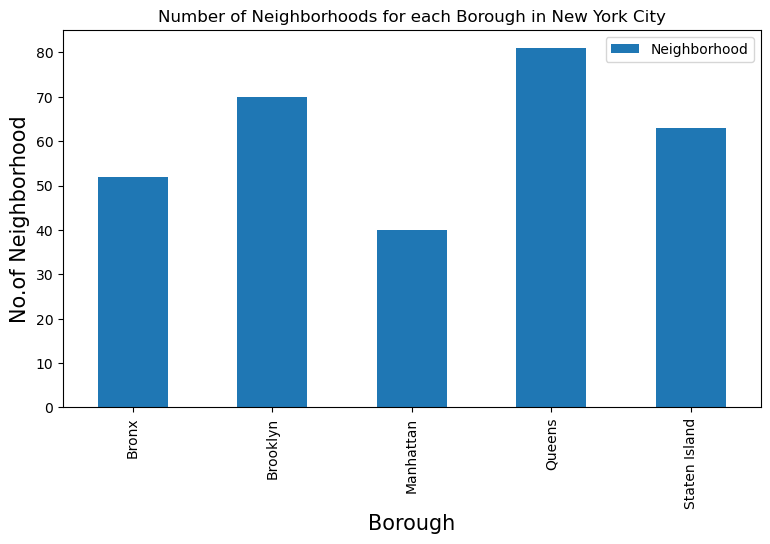

In [88]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhoods for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [32]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
japanese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    japanese_resturants=venues[venues['Category']=='Japanese Restaurant']   
    print('(',count,'/',len(new_york_data),')','Japanese Resturants in '+Neighborhood+', '+Borough+':'+str(len(japanese_resturants)))
    for resturant_detail in japanese_resturants.values.tolist():
        id, name , category=resturant_detail
        japanese_rest_ny = japanese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Japanese Resturants in Wakefield, Bronx:0
( 2 / 306 ) Japanese Resturants in Co-op City, Bronx:0
( 3 / 306 ) Japanese Resturants in Eastchester, Bronx:0
( 4 / 306 ) Japanese Resturants in Fieldston, Bronx:0
( 5 / 306 ) Japanese Resturants in Riverdale, Bronx:0
( 6 / 306 ) Japanese Resturants in Kingsbridge, Bronx:0
( 7 / 306 ) Japanese Resturants in Marble Hill, Manhattan:0
( 8 / 306 ) Japanese Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Japanese Resturants in Norwood, Bronx:0
( 10 / 306 ) Japanese Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Japanese Resturants in Baychester, Bronx:0
( 12 / 306 ) Japanese Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Japanese Resturants in City Island, Bronx:0
( 14 / 306 ) Japanese Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Japanese Resturants in University Heights, Bronx:0
( 16 / 306 ) Japanese Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Japanese Resturants in Fordham, Bronx:0
( 18 / 306 ) Japanese Resturants in Ea

( 138 / 306 ) Japanese Resturants in Richmond Hill, Queens:0
( 139 / 306 ) Japanese Resturants in Flushing, Queens:0
( 140 / 306 ) Japanese Resturants in Long Island City, Queens:0
( 141 / 306 ) Japanese Resturants in Sunnyside, Queens:0
( 142 / 306 ) Japanese Resturants in East Elmhurst, Queens:0
( 143 / 306 ) Japanese Resturants in Maspeth, Queens:1
( 144 / 306 ) Japanese Resturants in Ridgewood, Queens:0
( 145 / 306 ) Japanese Resturants in Glendale, Queens:0
( 146 / 306 ) Japanese Resturants in Rego Park, Queens:1
( 147 / 306 ) Japanese Resturants in Woodhaven, Queens:0
( 148 / 306 ) Japanese Resturants in Ozone Park, Queens:0
( 149 / 306 ) Japanese Resturants in South Ozone Park, Queens:0
( 150 / 306 ) Japanese Resturants in College Point, Queens:0
( 151 / 306 ) Japanese Resturants in Whitestone, Queens:0
( 152 / 306 ) Japanese Resturants in Bayside, Queens:0
( 153 / 306 ) Japanese Resturants in Auburndale, Queens:0
( 154 / 306 ) Japanese Resturants in Little Neck, Queens:1
( 155 

( 272 / 306 ) Japanese Resturants in Sutton Place, Manhattan:1
( 273 / 306 ) Japanese Resturants in Hunters Point, Queens:3
( 274 / 306 ) Japanese Resturants in Turtle Bay, Manhattan:3
( 275 / 306 ) Japanese Resturants in Tudor City, Manhattan:1
( 276 / 306 ) Japanese Resturants in Stuyvesant Town, Manhattan:0
( 277 / 306 ) Japanese Resturants in Flatiron, Manhattan:4
( 278 / 306 ) Japanese Resturants in Sunnyside Gardens, Queens:2
( 279 / 306 ) Japanese Resturants in Blissville, Queens:0
( 280 / 306 ) Japanese Resturants in Fulton Ferry, Brooklyn:1
( 281 / 306 ) Japanese Resturants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) Japanese Resturants in Weeksville, Brooklyn:0
( 283 / 306 ) Japanese Resturants in Broadway Junction, Brooklyn:0
( 284 / 306 ) Japanese Resturants in Dumbo, Brooklyn:0
( 285 / 306 ) Japanese Resturants in Manor Heights, Staten Island:0
( 286 / 306 ) Japanese Resturants in Willowbrook, Staten Island:0
( 287 / 306 ) Japanese Resturants in Sandy Ground, Staten Island:0

In [33]:
japanese_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Belmont,4baeef6bf964a520cbe23be3,Sake II
1,Brooklyn,Greenpoint,5f0254e274523a3e94fe11eb,ACRE
2,Brooklyn,Manhattan Terrace,4bf890acabdaef3b69b7a184,Masake
3,Brooklyn,Kensington,4d5c12a01e43236a87eb1583,Sake Sushi
4,Brooklyn,Prospect Heights,5cb5e5f9a35f4600255406c6,Maison Yaki


In [35]:
japanese_rest_ny.shape

(88, 4)

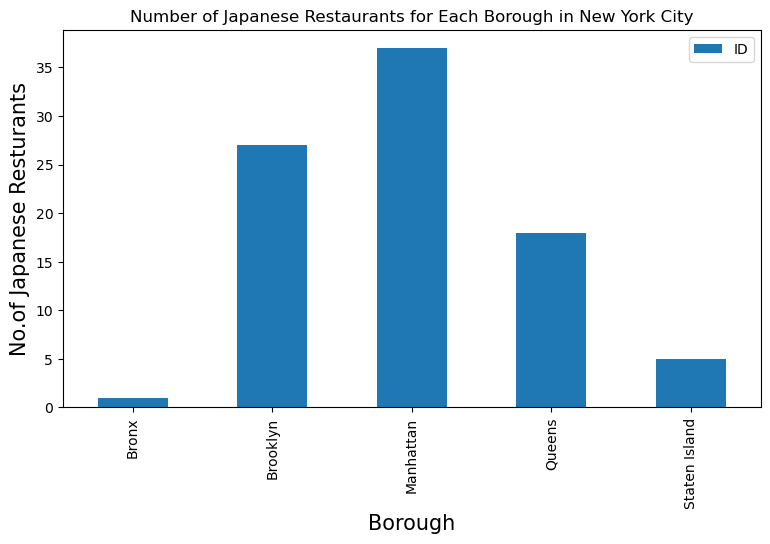

In [90]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Japanese Restaurants for Each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Japanese Resturants', fontsize=15)
#giving a bar plot
japanese_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

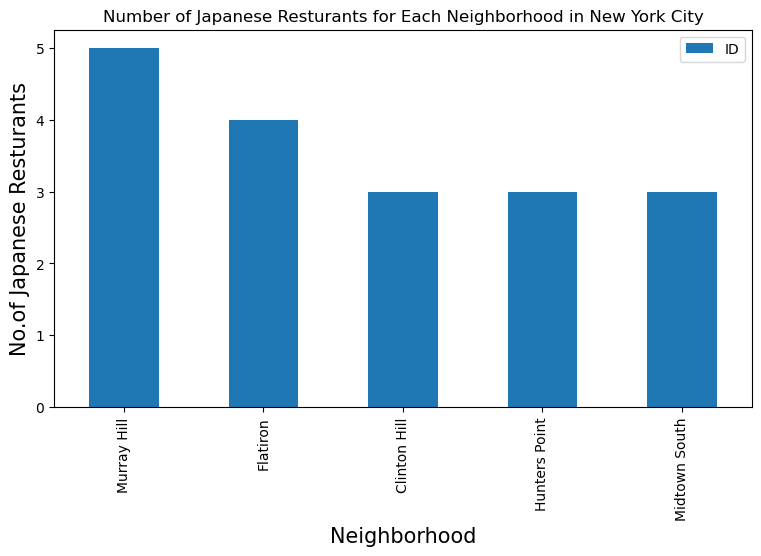

In [91]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Japanese Resturants for Each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Japanese Resturants', fontsize=15)
#giving a bar plot
japanese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [39]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Murray Hill']

,Borough,Neighborhood,ID,Name
31,Manhattan,Murray Hill,4a99b4f4f964a520f62f20e3,Kajitsu
32,Manhattan,Murray Hill,559cbaa6498eaa4e8d884811,Tempura Matsui
33,Manhattan,Murray Hill,591caee89deb7d0f69be77a2,Omusubi Gonbei
34,Manhattan,Murray Hill,48c50c4bf964a520dc511fe3,Café Zaiya
55,Queens,Murray Hill,4bc8eee83740b713fcbe5d65,Northern Sushi


In [40]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Flatiron']

,Borough,Neighborhood,ID,Name
81,Manhattan,Flatiron,5bd7a5561c675b0039be9acc,HALL
82,Manhattan,Flatiron,4f7b61f6e4b07aaa5d524842,OOTOYA 大戸屋 (OOTOYA)
83,Manhattan,Flatiron,581a10901df6b32e66ec3a07,Sugarfish
84,Manhattan,Flatiron,55805bb5498e8356d675aa22,Yakiniku Futago


In [41]:
japanese_rest_ny[japanese_rest_ny['Neighborhood']=='Midtown South']

,Borough,Neighborhood,ID,Name
66,Manhattan,Midtown South,57ab615d498eef084faa348b,Abiko Curry
67,Manhattan,Midtown South,5d7a9d59a369d40008dfcc1a,Konbini
68,Manhattan,Midtown South,58b8ed467220e661ddf34104,KazuNori: The Original Hand Roll Bar


In [43]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
japanese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in japanese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(japanese_rest_ny),')','processed')
    japanese_rest_stats_ny = japanese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID     Name  Likes  Rating  Tips
0  4baeef6bf964a520cbe23be3  Sake II      7     7.3    13
( 1 / 88 ) processed
                         ID  Name  Likes  Rating  Tips
0  5f0254e274523a3e94fe11eb  ACRE      7     8.2     1
( 2 / 88 ) processed
                         ID    Name  Likes  Rating  Tips
0  4bf890acabdaef3b69b7a184  Masake      6     6.4     6
( 3 / 88 ) processed
                         ID        Name  Likes  Rating  Tips
0  4d5c12a01e43236a87eb1583  Sake Sushi     31     7.7    49
( 4 / 88 ) processed
                         ID         Name  Likes  Rating  Tips
0  5cb5e5f9a35f4600255406c6  Maison Yaki     82     7.9    23
( 5 / 88 ) processed
                         ID          Name  Likes  Rating  Tips
0  51f9b7b3498eefe896caeb23  Shalom Japan    299     8.1    99
( 6 / 88 ) processed
                         ID    Name  Likes  Rating  Tips
0  5b3bcb69bfc6d0002ca9bf17  Warude     30     8.3     6
( 7 / 88 ) processed
                         ID

KeyError: 'venue'

In [44]:
japanese_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Belmont,4baeef6bf964a520cbe23be3,Sake II,7,7.3,13
1,Brooklyn,Greenpoint,5f0254e274523a3e94fe11eb,ACRE,7,8.2,1
2,Brooklyn,Manhattan Terrace,4bf890acabdaef3b69b7a184,Masake,6,6.4,6
3,Brooklyn,Kensington,4d5c12a01e43236a87eb1583,Sake Sushi,31,7.7,49
4,Brooklyn,Prospect Heights,5cb5e5f9a35f4600255406c6,Maison Yaki,82,7.9,23


In [45]:
japanese_rest_stats_ny.shape

(49, 7)

In [46]:
japanese_rest_ny.shape

(88, 4)

In [50]:
japanese_rest_stats_ny.to_csv('japanese_rest_stats_ny.csv', index=False)

In [51]:
japanese_rest_stats_ny_csv=pd.read_csv('japanese_rest_stats_ny.csv')

In [52]:
japanese_rest_stats_ny_csv.shape

(49, 7)

In [53]:
japanese_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Belmont,4baeef6bf964a520cbe23be3,Sake II,7,7.3,13
1,Brooklyn,Greenpoint,5f0254e274523a3e94fe11eb,ACRE,7,8.2,1
2,Brooklyn,Manhattan Terrace,4bf890acabdaef3b69b7a184,Masake,6,6.4,6
3,Brooklyn,Kensington,4d5c12a01e43236a87eb1583,Sake Sushi,31,7.7,49
4,Brooklyn,Prospect Heights,5cb5e5f9a35f4600255406c6,Maison Yaki,82,7.9,23


In [54]:
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       49 non-null     object 
 1   Neighborhood  49 non-null     object 
 2   ID            49 non-null     object 
 3   Name          49 non-null     object 
 4   Likes         49 non-null     object 
 5   Rating        49 non-null     float64
 6   Tips          49 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.8+ KB


In [56]:
japanese_rest_stats_ny['Likes']=japanese_rest_stats_ny['Likes'].astype('float64')
japanese_rest_stats_ny['Tips']=japanese_rest_stats_ny['Tips'].astype('float64')

In [57]:
japanese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       49 non-null     object 
 1   Neighborhood  49 non-null     object 
 2   ID            49 non-null     object 
 3   Name          49 non-null     object 
 4   Likes         49 non-null     float64
 5   Rating        49 non-null     float64
 6   Tips          49 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.8+ KB


In [58]:
# Resturant with maximum Likes
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Likes'].idxmax()]

Borough                         Brooklyn
Neighborhood                  North Side
ID              4c7f0887fb74236a7727f9b9
Name                        Samurai Mama
Likes                                898
Rating                               8.9
Tips                                 247
Name: 18, dtype: object

In [59]:
# Resturant with maximum Rating
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                East Village
ID              510c85e7e4b0056826b88297
Name                                Kura
Likes                                213
Rating                               9.3
Tips                                  63
Name: 36, dtype: object

In [60]:
# Resturant with maximum Tips
japanese_rest_stats_ny.iloc[japanese_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              454f7cc4f964a520dc3c1fe3
Name                            Morimoto
Likes                                792
Rating                               8.9
Tips                                 353
Name: 35, dtype: object

In [62]:
ny_neighborhood_stats=japanese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [63]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
11,East Village,9.30
9,Cobble Hill,9.00
4,Boerum Hill,8.90
7,Chelsea,8.90
25,North Side,8.90
10,Downtown,8.80
13,Fort Greene,8.80
26,Park Slope,8.80
29,Soho,8.70
20,Little Italy,8.55


In [64]:
ny_borough_stats= japanese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [84]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.273913
1,Brooklyn,8.072727
3,Queens,7.733333
0,Bronx,7.300000


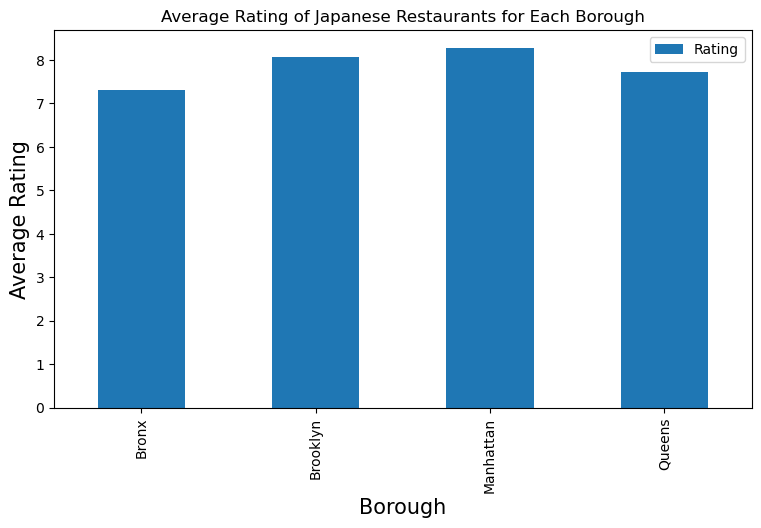

In [92]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average Rating of Japanese Restaurants for Each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
japanese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [85]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [86]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating,Label
0,Brooklyn,Cobble Hill,40.687920,-73.998561,9.0,"Cobble Hill, Brooklyn(9.0)"
1,Manhattan,East Village,40.727847,-73.982226,9.3,"East Village, Manhattan(9.3)"


In [71]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [72]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [73]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Cobble Hill,40.687920,-73.998561,9.0
1,Manhattan,East Village,40.727847,-73.982226,9.3


In [76]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [79]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the neighborhood and add each to the feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [80]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [81]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [83]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough_Boundaries.geojson'

map = ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

FileNotFoundError: [Errno 2] No such file or directory: 'Borough_Boundaries.geojson'

In [ ]:
xxxxxxxxxxxxxxxxx

In [ ]:
xxxx